In [8]:
import csv
import pandas
import matplotlib
#%matplotlib inline
import matplotlib.pyplot as plt
import collections
import re
from pathlib import Path, PureWindowsPath
import numpy as np


#plt.rc('font', family='serif', serif='Times')
#plt.rc('text', usetex=True)
#plt.rc('xtick', labelsize=8)
#plt.rc('ytick', labelsize=8)
#plt.rc('axes', labelsize=8)

# Calculate the pls charge character for each structure

In [9]:
#import data files
computer_mac="/Users/caixiuhong"
computer_dell=r'C:\Users\PC'

file1_path=Path(computer_dell+r"/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/crg_detail_ba3_clustering_PLS.csv")
file2_path=Path(computer_dell+r"/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/crg_detail_ba3_clustering_PLS2.csv")
file3_path=Path(computer_dell+r"/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/crg_detail_ba3_xray.csv")



file1 = pandas.read_csv(file1_path)
file2 = pandas.read_csv(file2_path)
file3 = pandas.read_csv(file3_path)




# append the datafranes together
df=file1.append(file2, ignore_index = True)

#reshape the dataframe
new=df['state_snap'].str.split(r"\+|_", expand = True)
df['traj/xry']=new[0]
df['time_point']=new[1]
df['substate']=new[3]

new=file3['state_snap'].str.split(r'\+|_', expand=True)
file3['traj/xry']=new[0]
file3['substate']=new[1]

df= df.append(file3, ignore_index=True)[df.columns.tolist()]


In [10]:
#calculate sum of charges at 24-res PLS for each substate and each structures
df['sum_pls24']=df.iloc[:,1:17].sum(axis=1)


# calculate sum of charges at 6-res PLS for each substate and each structures
pls=['PAAK9301', 'PDDK9302','DA0287', 'DA0372', 'HA0376', 'EB0126']
df['sum_pls6']=0
for i in pls:
    df['sum_pls6'] += df[i]


In [11]:
#check if the other 18 putative pls residues change their ionization.
for key in df:
    if key=='state_snap' or key in pls: continue
    if len(set(df[key])) != 1: print(key)

for i, x in enumerate(df['YA0136']):
    if x != -0.0:
        print(i,x)
        print('struct: %s, YA136 charge: %f' % (df.iloc[i]['state_snap'], df.iloc[i]['YA0136']))        

YA0133
YA0136
DA0372.1
EB0015
EB0126.1
HA0376.1
PAAK9301.1
PDDK9302.1
DA0287.1
traj/xry
time_point
substate
sum_pls24
sum_pls6
1202 -0.01
struct: 3eh3+f3, YA136 charge: -0.010000


In [12]:
for i, x in enumerate(df['DA0287']):
    if x != -1.0:
        print(i,x)
        print('struct: %s, DA287 charge: %f' % (df.iloc[i]['state_snap'], df.iloc[i]['DA0287']))    

295 -0.98
struct: d372ph376p_456_frame+e1, DA287 charge: -0.980000


In [13]:
def IntegralIncrease1(nums: list) ->float:
    #method 1:
    #return the sum of all local max-local min
    #start from beginning point: r5 substate
    
    loc_min, loc_max=nums[0], nums[0]
    res=0
    for i in range(1, len(nums)):
        if nums[i] > nums[i-1]:
            loc_max = nums[i]
        elif nums[i] < nums[i-1]:
            res += loc_max - loc_min
            loc_min=nums[i]
            loc_max=nums[i]
    res += loc_max-loc_min
    return res

def IntegralIncrease2(nums: list)->float:
    #method2:
    #return the sum of all local max-local min
    #start from second last one point: r1 substate
    
    loc_min, loc_max=nums[-2], nums[-2]
    res=0
    for i in range(-1, len(nums)-1):
        if nums[i] > nums[i-1]:
            loc_max = nums[i]
        elif nums[i] < nums[i-1]:
            res += loc_max - loc_min
            loc_min=nums[i]
            loc_max=nums[i]
    
    res += loc_max-loc_min
    return res



def crgstringtolist(crg_s: str)->list:
    #fuction to read crg_seq from string into crg set
    #return a list of charges
    n=len(crg_s)
    i=0
    res=[]
    while i < n:
        if crg_s[i]=='1':
            res.append(1)
            i +=1
        elif crg_s[i]=='0':
            res.append(0)
            i +=1
        else:
            res.append(int(crg_s[i:i+2]))
            i +=2
    return res

def readMsE2df(dicts: dict, substate: str): 
    #read all_ms_E format file, and output structure and energy informations
    #return a dataframe
    substate=str(substate)
    df_e1=[]
    columns_e1=['state_snap', 'E(-3)_min_'+substate, 'E(-4)_min_'+substate, 'str_ms(-3)_minE_'+substate, 'str_ms(-4)_minE_'+substate,\
                'ms(-3)_minE_'+substate, 'ms(-4)_minE_'+substate,\
                'E_self(-3)_'+substate,'E_self(-4)_'+substate, 
                'E_pw(-3)_'+substate,'E_pw(-4)_'+substate,\
                'E_mfe(-3)_'+substate,'E_mfe(-4)_'+substate,\
                r'$\bigtriangleup$E_'+substate,\
                r'$\bigtriangleup$E_self_'+substate,
                r'$\bigtriangleup$E_pw_'+substate, r'$\bigtriangleup$E_mfe_'+substate,
                'E_self_pka(-3)_'+substate,'E_self_vdw0(-3)_'+substate,'E_self_vdw1(-3)_'+substate,'E_self_epol(-3)_'+substate,
                'E_self_tors(-3)_'+substate,'E_self_dsolv(-3)_'+substate,
                'E_self_pka(-4)_'+substate,'E_self_vdw0(-4)_'+substate,'E_self_vdw1(-4)_'+substate,'E_self_epol(-4)_'+substate,
                'E_self_tors(-4)_'+substate,'E_self_dsolv(-4)_'+substate,
                r'$\bigtriangleup$E_self_pka_'+substate,
                r'$\bigtriangleup$E_self_vdw0_'+substate,
                r'$\bigtriangleup$E_self_vdw1_'+substate,
                r'$\bigtriangleup$E_self_epol_'+substate,
                r'$\bigtriangleup$E_self_tors_'+substate,
                r'$\bigtriangleup$E_self_dsolv_'+substate]

    ##read data into df_e1
    for struc, dataframe in dicts.items():
        tmp=dataframe.iloc[:7]  #summary for all charge state energy details
        data=[struc]
        data.append(tmp['Min_E(Kcal)'][2])
        data.append(tmp['Min_E(Kcal)'][1])
        data.append(tmp['Crg_seq'][2])
        data.append(tmp['Crg_seq'][1])
        data.append(crgstringtolist(tmp['Crg_seq'][2]))
        data.append(crgstringtolist(tmp['Crg_seq'][1]))
        data.extend([tmp['E_self(Kcal)'][2],tmp['E_self(Kcal)'][1], tmp['E_pw(Kcal)'][2],tmp['E_pw(Kcal)'][1],\
                     tmp['E_mfe(Kcal)'][2],tmp['E_mfe(Kcal)'][1]])
        data.append(tmp['Min_E(Kcal)'][1]-tmp['Min_E(Kcal)'][2])
        data.append(tmp['E_self(Kcal)'][1]-tmp['E_self(Kcal)'][2])
        data.append(tmp['E_pw(Kcal)'][1]-tmp['E_pw(Kcal)'][2])
        data.append((tmp['E_mfe(Kcal)'][1]-tmp['E_mfe(Kcal)'][2])*2)
        
        
        tmp1=dataframe.iloc[9:16]  #summary for all charge state energy details AT -3MS
        data.extend([tmp1.iloc[1:7, 5].sum(), tmp1.iloc[1:7, 6].sum(), tmp1.iloc[1:7, 7].sum(),
                    tmp1.iloc[1:7, 8].sum(),tmp1.iloc[1:7, 9].sum(),tmp1.iloc[1:7, 10].sum()])
        
        tmp2=dataframe.iloc[31:38]  #summary for all charge state energy details AT -4MS
        data.extend([tmp2.iloc[1:7, 5].sum(), tmp2.iloc[1:7, 6].sum(), tmp2.iloc[1:7, 7].sum(),
                    tmp2.iloc[1:7, 8].sum(),tmp2.iloc[1:7, 9].sum(),tmp2.iloc[1:7, 10].sum()])
        
        data.extend([tmp2.iloc[1:7, 5].sum()-tmp1.iloc[1:7, 5].sum(), 
                     tmp2.iloc[1:7, 6].sum()-tmp1.iloc[1:7, 6].sum(),
                     tmp2.iloc[1:7, 7].sum()-tmp1.iloc[1:7, 7].sum(),
                    tmp2.iloc[1:7, 8].sum()-tmp1.iloc[1:7, 8].sum(),
                     tmp2.iloc[1:7, 9].sum()-tmp1.iloc[1:7, 9].sum(),
                     tmp2.iloc[1:7, 10].sum()-tmp1.iloc[1:7, 10].sum()])
        
        df_e1.append(data)
    
    return pandas.DataFrame(df_e1, columns = columns_e1)    


def readMsE2df2(dicts: dict, substate: str): 
    #read all_ms_E format file, and output structure and energy informations
    #return a dataframe
    substate=str(substate)
    df_e1=[]
    columns_e1=['state_snap', 'E(-3)_min_'+substate, 'E(-4)_min_'+substate, 'str_ms(-3)_minE_'+substate, 'str_ms(-4)_minE_'+substate,\
                'ms(-3)_minE_'+substate, 'ms(-4)_minE_'+substate,\
                'E_self(-3)_'+substate,'E_self(-4)_'+substate, 
                'E_pw(-3)_'+substate,'E_pw(-4)_'+substate,\
                'E_mfe(-3)_'+substate,'E_mfe(-4)_'+substate,\
                r'$\bigtriangleup$E_'+substate,\
                r'$\bigtriangleup$E_self_'+substate,
                r'$\bigtriangleup$E_pw_'+substate, r'$\bigtriangleup$E_mfe_'+substate,
                'E_self_pka(-3)_'+substate,'E_self_vdw0(-3)_'+substate,'E_self_vdw1(-3)_'+substate,'E_self_epol(-3)_'+substate,
                'E_self_tors(-3)_'+substate,'E_self_dsolv(-3)_'+substate,
                'E_self_pka(-4)_'+substate,'E_self_vdw0(-4)_'+substate,'E_self_vdw1(-4)_'+substate,'E_self_epol(-4)_'+substate,
                'E_self_tors(-4)_'+substate,'E_self_dsolv(-4)_'+substate,
                r'$\bigtriangleup$E_self_pka_'+substate,
                r'$\bigtriangleup$E_self_vdw0_'+substate,
                r'$\bigtriangleup$E_self_vdw1_'+substate,
                r'$\bigtriangleup$E_self_epol_'+substate,
                r'$\bigtriangleup$E_self_tors_'+substate,
                r'$\bigtriangleup$E_self_dsolv_'+substate]

    ##read data into df_e1
    for struc, dataframe in dicts.items():
        gaprow=dataframe[dataframe[2].isnull()].index[0]
        
        tmp=dataframe.iloc[:gaprow]  #summary for all charge state energy details
        data=[struc]
        ms_3data=dataframe[dataframe[2]==-3].iloc[0]
        ms_4data=dataframe[dataframe[2]==-4].iloc[0]
        
        
        if len(set(dataframe[dataframe[2]==-3][2])) !=1  or len(set(dataframe[dataframe[2]==-4][2])) !=1 or \
        dataframe[dataframe[2]==-3][4].min() != dataframe[dataframe[2]==-3][4].iloc[0] or \
        dataframe[dataframe[2]==-4][4].min() != dataframe[dataframe[2]==-4][4].iloc[0]: # check if energy data format is right
            print('Warning: check the energy data format!')
            return
        
        data.append(ms_3data[4])
        data.append(ms_4data[4])
        data.append(ms_3data[3])
        data.append(ms_4data[3])
        data.append(crgstringtolist(ms_3data[3]))
        data.append(crgstringtolist(ms_4data[3]))
        data.extend([ms_3data[5],ms_4data[5], ms_3data[6],ms_4data[6],\
                     ms_3data[7],ms_4data[7]])
        data.append(ms_4data[4]-ms_3data[4])
        data.append(ms_4data[5]-ms_3data[5])
        data.append(ms_4data[6]-ms_3data[6])
        data.append((ms_4data[7]-ms_3data[7])*2)
        
        
        tmp1=dataframe.iloc[gaprow+2:gaprow+9]  #summary for all charge state energy details AT -3MS
        data.extend([tmp1.iloc[1:7, 5].sum(), tmp1.iloc[1:7, 6].sum(), tmp1.iloc[1:7, 7].sum(),
                    tmp1.iloc[1:7, 8].sum(),tmp1.iloc[1:7, 9].sum(),tmp1.iloc[1:7, 10].sum()])
        
        tmp2=dataframe.iloc[gaprow+24:gaprow+31]  #summary for all charge state energy details AT -4MS
        data.extend([tmp2.iloc[1:7, 5].sum(), tmp2.iloc[1:7, 6].sum(), tmp2.iloc[1:7, 7].sum(),
                    tmp2.iloc[1:7, 8].sum(),tmp2.iloc[1:7, 9].sum(),tmp2.iloc[1:7, 10].sum()])
        
        data.extend([tmp2.iloc[1:7, 5].sum()-tmp1.iloc[1:7, 5].sum(), 
                     tmp2.iloc[1:7, 6].sum()-tmp1.iloc[1:7, 6].sum(),
                     tmp2.iloc[1:7, 7].sum()-tmp1.iloc[1:7, 7].sum(),
                    tmp2.iloc[1:7, 8].sum()-tmp1.iloc[1:7, 8].sum(),
                     tmp2.iloc[1:7, 9].sum()-tmp1.iloc[1:7, 9].sum(),
                     tmp2.iloc[1:7, 10].sum()-tmp1.iloc[1:7, 10].sum()])
        
        df_e1.append(data)
        
    return pandas.DataFrame(df_e1, columns = columns_e1) 


def color_struc(s, color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    #copy df to new - original data are not changed
    df = s.copy()
    #set by condition
    df.loc[:,:] = 'background-color: blue '
    for key in color_map:
        
        mask = s[column] == key
        #print(mask)
        df.loc[mask, :] = 'background-color: {}'.format(color_map.get(key))
    #print(df)
    return df    


def readClusteringFile(file, dataframe):
    #read clustering information from filepath and append the information into dataframe
    
    columns=['traj/xray', 'time_point','cluster_size']
    with open(file, 'r') as f:
        next(f)
        data=[]
        for line in f:
            line=line.strip()
            if line:
                line= re.split(':|,|\(|\)' , line)
                
                if len(line)==1: continue
                if len(line)==2:  # read the traj/xry information
                    struc=line[0]
                    continue
                time_point=int(line[4])
                cluster_size=int(line[2])
                data.append([struc, str(time_point), cluster_size])
    
    df=pandas.DataFrame(data, columns = columns)
    #print(df)
    return pandas.merge(dataframe, df, how='outer', on =['traj/xray','time_point'])

def colormaps(color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    n=len(column)
    ans=[''] * n
    for i, x in enumerate(column):
        ans[i]=color_map.get(x,'blue')
        #print(x, ans[i])
    return ans
    

        

### result: YA136 has -0.01 charge compared to 0.0 at structure 3eh3

d372p_151_frame has max_proton_affinity at substate 7 with charge -3.000000, E1 substate has charge -3.000000.
d372p_151_frame has min_proton_affinity at substate 2 with charge -4.000000, f3 substate has charge -4.000000.
d372p_152_frame has max_proton_affinity at substate 7 with charge -3.000000, E1 substate has charge -3.000000.
d372p_152_frame has min_proton_affinity at substate 2 with charge -4.000000, f3 substate has charge -4.000000.
d372p_167_frame has max_proton_affinity at substate 7 with charge -3.000000, E1 substate has charge -3.000000.
d372p_167_frame has min_proton_affinity at substate 2 with charge -4.000000, f3 substate has charge -4.000000.
d372p_179_frame has max_proton_affinity at substate 7 with charge -3.000000, E1 substate has charge -3.000000.
d372p_179_frame has min_proton_affinity at substate 2 with charge -4.000000, f3 substate has charge -4.000000.
d372p_18_frame has max_proton_affinity at substate 7 with charge -3.000000, E1 substate has charge -3.000000.
d3

p2_359_frame has min_proton_affinity at substate 2 with charge -4.000000, f3 substate has charge -4.000000.
p2_361_frame has min_proton_affinity at substate 2 with charge -4.000000, f3 substate has charge -4.000000.
p2_364_frame has min_proton_affinity at substate 0 with charge -4.000000, f3 substate has charge -4.000000.
p2_39_frame has max_proton_affinity at substate 7 with charge -3.980000, E1 substate has charge -3.980000.
p2_39_frame has min_proton_affinity at substate 0 with charge -4.000000, f3 substate has charge -4.000000.
p2_402_frame has min_proton_affinity at substate 0 with charge -4.000000, f3 substate has charge -4.000000.
p2_423_frame has max_proton_affinity at substate 7 with charge -3.950000, E1 substate has charge -3.950000.
p2_423_frame has min_proton_affinity at substate 0 with charge -4.000000, f3 substate has charge -4.000000.
p2_432_frame has min_proton_affinity at substate 2 with charge -3.990000, f3 substate has charge -3.990000.
p2_465_frame has max_proton_af

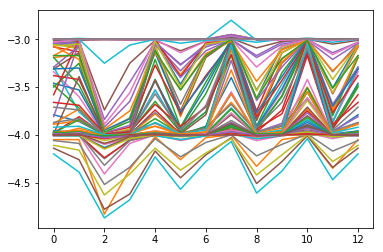

number of structures that E1 is not max_proton_affinity: 53,
number of structures that F3 is not min_proton_affinity: 103.
total number of structures that has proton affinity fluctuations: 94.


In [14]:
#crate a new dataframe to store information of each structure
df_sum=[]
n_substate=12
#generate headers for df_sum dataframe
columns=['state_snap','traj/xray', 'time_point']
for res in pls:
    columns.extend([res+'_maxcrg', res+'_mincrg',res+'_avecrg', res+'_std',res+'_avecrg\u00B1'+'std'])

columns.extend(['pls_res_cov'])    
columns.extend(['sum_pls6_maxcrg', 'sum_pls6_mincrg',r'$\bigtriangleup$sum_pls6','sum_pls6_avecrg', 'sum_pls6_std',\
                'sum_pls6_avecrg\u00B1std', r'$\int$dsum_pls6_m1',r'$\int$dsum_pls6_m2'])
#print(columns)


plt.figure()
E1notmaxCount=0 # store the structures number that E1 is not substate with maximum proton affinity
F3notminCount=0 # store the structures number that f3 is not substate with minimum proton affinity
tot_waveCount=0  # store the structures number that the structure has the fluctuation for proton affinity



for i in range(0,df.shape[0],12):
    tmp=df.iloc[i:i+n_substate]
    state_snap=list(tmp['state_snap'])
    struc=set(tmp['traj/xry'])
    time_point=set(tmp['time_point'])
    if i>0 and substate != list(tmp['substate']):
        raise Warning ("substate sequence of structure %s dismatch!" %struc)
        break
    substate=list(tmp['substate'])
    #print(substate)
    
    #check if the structure name ,time_point are consistent, if there are 12 substates for each structure
    if len(state_snap)==12 and len(struc) == 1 and len(time_point)==1 and len(substate)==12:
        state_snap=state_snap.pop()[:-3]
        data= [state_snap, struc.pop(), time_point.pop() ]
    else:
        raise Warning("The traj/xry or time_point or substate is not consistent!") # assign the structure name or print out "WARNING"
    
    
    #calculate charge statistic for each residue
    for res in pls:
        data.extend([max(tmp[res]), min(tmp[res]), tmp[res].mean(),tmp[res].std(), \
                     '{:.2f} \u00B1 {:0.2f}'.format(tmp[res].mean(), tmp[res].std())])
    
    #store the charge of each residue in pls with 12 substates
    #calculate the covariance of 6 residues
    res_crg_df=df.loc[i:i+n_substate-1, pls]   
    data.extend([res_crg_df.cov()])
    
    #compute sum_crg of pls statistic
    data.extend([tmp['sum_pls6'].max(), tmp['sum_pls6'].min(), tmp['sum_pls6'].max()- tmp['sum_pls6'].min(),\
                 tmp['sum_pls6'].mean(),tmp['sum_pls6'].std(),
                 '{:.2f} \u00B1 {:0.2f}'.format(tmp['sum_pls6'].mean(), tmp['sum_pls6'].std())] )
    
   
    
    
    
    #integral of sum_pls6 charge change
    sum_pls=list(tmp['sum_pls6'])
    #print(sum_pls)
    
    integral_sum_pls61=IntegralIncrease1(sum_pls)
    integral_sum_pls62=IntegralIncrease2(sum_pls)
    
    #plot figure
    plt.plot(sum_pls+sum_pls[:1])
    
    #check if E1 is the maximum proton affinity substate, and f3 is the minimum proton affinity substate.
    if max(sum_pls) > min(sum_pls):
        tot_waveCount += 1
        if sum_pls[7] == max(sum_pls): # not E1 substate
            print("%s has max_proton_affinity at substate %i with charge %f, E1 substate has charge %f." %(state_snap, \
                                                                                                           sum_pls.index(max(sum_pls)), max(sum_pls), sum_pls[7]))
            E1notmaxCount +=1
    if sum_pls[2] == min(sum_pls): # f3 substate
        print("%s has min_proton_affinity at substate %i with charge %f, f3 substate has charge %f." %(state_snap, \
              sum_pls.index(min(sum_pls)), min(sum_pls), sum_pls[2])) 
        F3notminCount +=1
    
    
    
        
            
    data.extend([integral_sum_pls61,integral_sum_pls62 ])
    
    df_sum.append(data)
    #df_sum['state_snap'].append(df.iloc[i:i+12]['state_snap'])
    #print(df.iloc[i:i+12]['substate'])


plt.show()
df_sum = pandas.DataFrame(df_sum, columns = columns)
print('number of structures that E1 is not max_proton_affinity: %i,\n\
number of structures that F3 is not min_proton_affinity: %i.\n\
total number of structures that has proton affinity fluctuations: %i.' % (E1notmaxCount, F3notminCount, tot_waveCount))

# Draw Proton uptake vs 12 Substate at selected structures

deltaH+1: 2.440000, deltaH+2: 2.450000.
p2_148_frame [-3.99, -3.39, -4.0, -4.0, -3.4299999999999997, -3.9899999999999998, -3.79, -3.01, -4.0, -4.0, -3.71, -4.0]


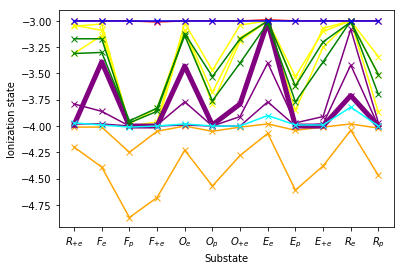

number of structures that E1 is max_proton_affinity: 67,
number of structures that R1 is max_proton_affinity: 74,
number of structures that F3 is min_proton_affinity: 103.
total number of structures that has proton affinity fluctuations: 94.


In [16]:
#crate a new dataframe to store information of each structure
df_sum=[]
n_substate=12
#generate headers for df_sum dataframe
columns=['state_snap','traj/xray', 'time_point']
for res in pls:
    columns.extend([res+'_maxcrg', res+'_mincrg',res+'_avecrg', res+'_std',res+'_avecrg\u00B1'+'std'])

columns.extend(['pls_res_cov'])    
columns.extend(['sum_pls6_maxcrg', 'sum_pls6_mincrg',r'$\bigtriangleup$sum_pls6','sum_pls6_avecrg', 'sum_pls6_std',\
                'sum_pls6_avecrg\u00B1std', r'$\int$dsum_pls6_m1',r'$\int$dsum_pls6_m2'])
#print(columns)



plt.figure()
outputpathway=Path(computer_dell+r"/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/")
#plt.figure(figsize=(10, 5))
x_label=['$R_{+e}$','$F_e$','$F_p$','$F_{+e}$','$O_e$','$O_p$','$O_{+e}$','$E_e$','$E_p$','$E_{+e}$','$R_e$', '$R_p$']
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}
selected_strucs=['3s8f','d372ph376p_166_frame','d372p_151_frame','d372p_207_frame',\
                 'p2_185_frame','d372p_253_frame','p3_98_frame','p3_443_frame', 'p4_32_frame',\
                'p1_188_frame','p1_428_frame', 'p2_25_frame','p2_148_frame']
plt.xticks(list(range(12)),x_label)


E1maxCount=0 # store the structures number that E1 is substate with maximum proton affinity
R1maxCount=0 # store the structures number that R1 is substate with maximum proton affinity
F3minCount=0 # store the structures number that f3 is substate with minimum proton affinity
tot_waveCount=0  # store the structures number that the structure has the fluctuation for proton affinity

for i in range(0,df.shape[0],12):
    tmp=df.iloc[i:i+n_substate]
    state_snap=list(tmp['state_snap'])
    struc=set(tmp['traj/xry'])
    time_point=set(tmp['time_point'])
    if i>0 and substate != list(tmp['substate']):
        raise Warning ("substate sequence of structure %s dismatch!" %struc)
        break
    substate=list(tmp['substate'])
    #print(substate)
    
    #check if the structure name ,time_point are consistent, if there are 12 substates for each structure
    if len(state_snap)==12 and len(struc) == 1 and len(time_point)==1 and len(substate)==12:
        state_snap=state_snap.pop()[:-3]
        data= [state_snap, struc.pop(), time_point.pop() ]
    else:
        raise Warning("The traj/xry or time_point or substate is not consistent!") # assign the structure name or print out "WARNING"
    
    #print(state_snap)
    #calculate charge statistic for each residue
    for res in pls:
        data.extend([max(tmp[res]), min(tmp[res]), tmp[res].mean(),tmp[res].std(), \
                     '{:.2f} \u00B1 {:0.2f}'.format(tmp[res].mean(), tmp[res].std())])
    
    #store the charge of each residue in pls with 12 substates
    #calculate the covariance of 6 residues
    res_crg_df=df.loc[i:i+n_substate-1, pls]   
    data.extend([res_crg_df.cov()])
    
    #compute sum_crg of pls statistic
    data.extend([tmp['sum_pls6'].max(), tmp['sum_pls6'].min(), tmp['sum_pls6'].max()- tmp['sum_pls6'].min(),\
                 tmp['sum_pls6'].mean(),tmp['sum_pls6'].std(),
                 '{:.2f} \u00B1 {:0.2f}'.format(tmp['sum_pls6'].mean(), tmp['sum_pls6'].std())] )
    
   
    
    
    
    #integral of sum_pls6 charge change
    sum_pls=list(tmp['sum_pls6'])
    #print(sum_pls)
    
    integral_sum_pls61=IntegralIncrease1(sum_pls)
    integral_sum_pls62=IntegralIncrease2(sum_pls)
    
    
    #plot figure
    color=color_maps.get(data[1],'blue')
    if state_snap in selected_strucs: 
        if 'd372ph376p' in struc: plt.plot(sum_pls, label=data[1]+'pls', alpha=1, color=color, marker='x',linestyle='-.')
        elif state_snap == 'p2_148_frame':
            plt.plot(sum_pls, label=data[1]+'pls', alpha=1, color=color, marker='x', linewidth=5.0)
            print('deltaH+1: %f, deltaH+2: %f.' %  (integral_sum_pls61, integral_sum_pls62))
            print('p2_148_frame',sum_pls)
        else:
            plt.plot(sum_pls, label=data[1]+'pls', alpha=1, color=color, marker='x')
        
    
    
    
    #check if E1 is the maximum proton affinity substate, and f3 is the minimum proton affinity substate.
    if max(sum_pls) > min(sum_pls):
        tot_waveCount += 1
        
    if sum_pls[7] == max(sum_pls): #  E1 substate
        #print("%s has max_proton_affinity at substate %i with charge %f, E1 substate has charge %f." %(state_snap, \
        #                                                                                           sum_pls.index(max(sum_pls)), max(sum_pls), sum_pls[7]))
        E1maxCount +=1
    if sum_pls[10] == max(sum_pls): #  R1 substate
        R1maxCount +=1
    if sum_pls[2] == min(sum_pls): # f3 substate
        #print("%s has min_proton_affinity at substate %i with charge %f, f3 substate has charge %f." %(state_snap, \
        #      sum_pls.index(min(sum_pls)), min(sum_pls), sum_pls[2])) 
        F3minCount +=1
    
    
    
        
            
    data.extend([integral_sum_pls61,integral_sum_pls62 ])
    
    df_sum.append(data)
    #df_sum['state_snap'].append(df.iloc[i:i+12]['state_snap'])
    #print(df.iloc[i:i+12]['substate'])

# get impose charge
impose_charge=[-1,-1,0,-1,-1,0,-1, -1,0,-1,-1,0]
#plt.plot(impose_charge, label='impose_charge', alpha=1, color='k', marker='o', markersize=10, markerfacecolor='none')
plt.xlabel('Substate')
plt.ylabel('Ionization state')
plt.savefig(str(outputpathway)+'/'+'All_Crg_State_ba3_clustering_selected_strucs2.tiff', dpi=300)
plt.show()
df_sum = pandas.DataFrame(df_sum, columns = columns)
print('number of structures that E1 is max_proton_affinity: %i,\n\
number of structures that R1 is max_proton_affinity: %i,\n\
number of structures that F3 is min_proton_affinity: %i.\n\
total number of structures that has proton affinity fluctuations: %i.' % (E1maxCount,R1maxCount, F3notminCount, tot_waveCount))

# Import proton binding energy into dataframe: df_sum

In [20]:
#import crystal and md at e1/f3 substate data files
filepath_cry_e1='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/all_ms_E.xlsx'
filepath_md_e1='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/all_ms_E_e1.xlsx'
#f3 data files pathway
filepath_cry_f3='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/all_ms_E_f3.xlsx'
filepath_md_f3='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/all_ms_E_f3.xlsx'

#crystal structure name
cry_name= ["1ehk","1xme","4gp4","4gp5","3eh3","3eh5","3s3b","3s3d","3eh4","3s3a","3s3c","3s8f"]


file_cry_e1 = pandas.read_excel(filepath_cry_e1, sheetname=cry_name, index_col=1)
file_md_e1 = pandas.read_excel(filepath_md_e1, sheetname=None, index_col=1)
file_cry_f3 = pandas.read_excel(filepath_cry_f3, sheetname=cry_name, index_col=1)
file_md_f3 = pandas.read_excel(filepath_md_f3, sheetname=None, index_col=1)


file_cry_e1.update(file_md_e1)
file_e1=file_cry_e1   # store data for e1 substate

file_cry_f3.update(file_md_f3)
file_f3= file_cry_f3   # store data for f3 substate


# read min_e, e_self, e_pw, e_mfe
df_e1=readMsE2df(file_e1,'e1')
df_f3=readMsE2df(file_f3,'f3')


In [21]:
#import crystal and md at f1/f5 substate data files
filepath_cry_f1='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/all_ms_E_f1.xlsx'
filepath_md_f1='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/all_ms_E_f1.xlsx'
#f3 data files pathway
filepath_cry_f5='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/all_ms_E_f5.xlsx'
filepath_md_f5='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/all_ms_E_f5.xlsx'

#crystal structure name
cry_name= ["1ehk","1xme","4gp4","4gp5","3eh3","3eh5","3s3b","3s3d","3eh4","3s3a","3s3c","3s8f"]


file_cry_f1 = pandas.read_excel(filepath_cry_f1, sheetname=cry_name, index_col=False, header=None)
file_md_f1 = pandas.read_excel(filepath_md_f1, sheetname=None, index_col=False, header=None)
file_cry_f5 = pandas.read_excel(filepath_cry_f5, sheetname=cry_name, index_col=False, header=None)
file_md_f5 = pandas.read_excel(filepath_md_f5, sheetname=None, index_col=False, header=None)


file_cry_f1.update(file_md_f1)
file_f1=file_cry_f1   # store data for e1 substate

file_cry_f5.update(file_md_f5)
file_f5= file_cry_f5   # store data for f3 substate


# read min_e, e_self, e_pw, e_mfe
df_f1=readMsE2df2(file_f1,'f1')
df_f5=readMsE2df2(file_f5,'f5')

In [22]:
#concatenate df_sum, df_e1, df_f3 together
df_res=pandas.merge(df_sum, df_e1, on='state_snap')
df_res=pandas.merge(df_res, df_f3, on='state_snap')
df_res=pandas.merge(df_res, df_f1, on='state_snap')
df_res=pandas.merge(df_res, df_f5, on='state_snap')

In [23]:
df_res

state_snap   traj/xray time_point  PAAK9301_maxcrg  \
0         d372p_151_frame       d372p        151            -0.00   
1         d372p_152_frame       d372p        152            -0.00   
2         d372p_167_frame       d372p        167            -0.00   
3         d372p_179_frame       d372p        179            -0.00   
4          d372p_18_frame       d372p         18            -0.79   
5         d372p_207_frame       d372p        207            -0.00   
6         d372p_230_frame       d372p        230            -0.01   
7         d372p_253_frame       d372p        253            -0.00   
8         d372p_287_frame       d372p        287            -0.00   
9         d372p_289_frame       d372p        289            -0.00   
10        d372p_318_frame       d372p        318            -0.02   
11        d372p_365_frame       d372p        365            -0.00   
12        d372p_370_frame       d372p        370            -0.00   
13        d372p_491_frame       d372p        491            -0.10   
14         d372p_54_frame       d372p         54            -0.24   
15   d372ph376p_141_frame  d372ph376p        141            -1.00   
16   d372ph376p_166_frame  d372ph376p        166            -0.92   
17   d372ph376p_243_frame  d372ph376p        243            -0.96   
18   d372ph376p_255_frame  d372ph376p        255            -0.99   
19   d372ph376p_288_frame  d372ph376p        288            -0.85   
20   d372ph376p_368_frame  d372ph376p        368            -1.00   
21   d372ph376p_404_frame  d372ph376p        404            -0.98   
22   d372ph376p_411_frame  d372ph376p        411            -0.38   
23   d372ph376p_432_frame  d372ph376p        432            -0.82   
24   d372ph376p_456_frame  d372ph376p        456            -0.97   
25   d372ph376p_468_frame  d372ph376p        468            -0.77   
26    d372ph376p_55_frame  d372ph376p         55            -1.00   
27    d372ph376p_68_frame  d372ph376p         68            -1.00   
28             p1_6_frame          p1          6            -0.31   
29           p1_428_frame          p1        428            -0.04   
..                    ...         ...        ...              ...   
78           p3_297_frame          p3        297            -0.71   
79           p3_435_frame          p3        435            -0.94   
80           p3_443_frame          p3        443            -0.00   
81           p3_467_frame          p3        467            -0.78   
82            p3_98_frame          p3         98            -0.00   
83           p4_113_frame          p4        113            -0.00   
84           p4_129_frame          p4        129            -0.01   
85           p4_131_frame          p4        131            -0.00   
86           p4_153_frame          p4        153            -0.02   
87           p4_168_frame          p4        168            -0.00   
88           p4_209_frame          p4        209            -0.00   
89           p4_219_frame          p4        219            -0.05   
90           p4_236_frame          p4        236            -0.20   
91            p4_25_frame          p4         25            -0.01   
92            p4_32_frame          p4         32            -0.01   
93            p4_45_frame          p4         45            -0.00   
94            p4_50_frame          p4         50            -0.01   
95            p4_64_frame          p4         64            -0.03   
96                   1ehk        1ehk        NaN            -1.00   
97                   1xme        1xme        NaN            -1.00   
98                   4gp4        4gp4        NaN            -1.00   
99                   4gp5        4gp5        NaN            -1.00   
100                  3eh3        3eh3        NaN            -1.00   
101                  3eh5        3eh5        NaN            -1.00   
102                  3s3b        3s3b        NaN            -1.00   
103                  3s3d        3s3d        NaN            -1.00   
104          

# read clustering information and append to df_res dataframe

In [24]:
clustering_pls_path=r'/Users/PC/Dropbox/cai/btype_cco/snapshot/clustering/clusters_PLS.txt'
#pathway of clustering informaton file

In [25]:
def readClusteringFile(file, dataframe):
    #read clustering information from filepath and append the information into dataframe
    
    columns=['traj/xray', 'time_point','cluster_size']
    with open(file, 'r') as f:
        next(f)
        data=[]
        for line in f:
            line=line.strip()
            if line:
                line= re.split(':|,|\(|\)' , line)
                
                if len(line)==1: continue
                if len(line)==2:  # read the traj/xry information
                    struc=line[0]
                    continue
                time_point=int(line[4])
                cluster_size=int(line[2])
                data.append([struc, str(time_point), cluster_size])
    
    df=pandas.DataFrame(data, columns = columns)
    #print(df)
    return pandas.merge(dataframe, df, how='outer', on =['traj/xray','time_point'])
        
    

In [26]:
df_res=readClusteringFile(clustering_pls_path, df_res)

# plot integreted proton uptake vs deltaE_e1

In [37]:
outputpath=r'/Users/PC/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/IntHvsDeltaE4.tiff'  # path to store the figure


def colormaps(color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    n=len(column)
    ans=[''] * n
    for i, x in enumerate(column):
        ans[i]=color_map.get(x,'blue')
        #print(x, ans[i])
    return ans
    
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}
colors=colormaps(color_maps, df_res['traj/xray'])

"""
fig, ax1=plt.subplots(figsize=(10,10))
color = 'tab:red'
ax1.scatter(df_res[r'$\bigtriangleup$E_e1'], df_res[r'$\int$dsum_pls6_m2'],marker='x',color=colors)
ax1.set_xlabel('∆∆GEe(UL-L)')
ax1.set_ylabel('∆H+', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=-2.9,color='k')
ax1.axvline(x=5.5,color='k')

color = 'k'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.errorbar(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_pls6_avecrg'],df_res['sum_pls6_std'],linestyle='None', marker='.', color='k')
ax2.set_ylabel('ionization state',color=color)
ax2.set_ylim((-10.0, -2.0)) 
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

#plt.savefig(outputpath, dpi=300)
plt.show()
"""


fig, ax=plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0} )

#label the figure
ax[0].text(-0.1, 1.05, 'A', transform=ax[0].transAxes,
      fontsize=16, va='top', ha='right')
ax[1].text(-0.1, 1.05, 'B', transform=ax[1].transAxes,
      fontsize=16,  va='top', ha='right')


ax[1].scatter(df_res[r'$\bigtriangleup$E_e1'], df_res[r'$\int$dsum_pls6_m2'],\
              edgecolors='k', linewidth='0.5', marker='o',color=colors, s=10)
ax[1].set_xlabel(r'$\bigtriangleup$$\bigtriangleup$$G^{E_e}_{UL-L}$')
ax[1].set_ylabel(r'$\bigtriangleup$$H^+$')
ax[1].tick_params(axis='y')
ax[1].axvline(x=-2.9,color='k')
ax[1].axvline(x=5.5,color='k')

ax[0].plot(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_pls6_avecrg'], 'ro', markersize=3)
#ax[0].errorbar(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_pls6_avecrg'],df_res['sum_pls6_std'], \
#               uplims=df_res['sum_pls6_maxcrg'],linestyle='None', \
#               capsize=3, color='k')
ax[0].errorbar(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_pls6_avecrg'],\
               [df_res['sum_pls6_avecrg']-df_res['sum_pls6_mincrg'],\
                df_res['sum_pls6_maxcrg']-df_res['sum_pls6_avecrg']], \
               linestyle='None', \
               capsize=1, color='k', lw=0.5)
ax[0].axvline(x=-2.9,color='k')
ax[0].axvline(x=5.5,color='k')
ax[0].set_ylabel('Ionization state')

#plt.setp(ax[0].get_xticklabels(), visible=False)  #hide the x axis label of first figure


#ax[0].set_ylim((-10.0, -2.0)) 
#ax[0].tick_params(axis='y' )
#fig.tight_layout()  # otherwise the right y-label is slightly clipped
for a in ax:
    a.label_outer()


plt.savefig(outputpath, dpi=300, bbox_inches='tight')
fig.show()



TypeError: Cannot cast array data from dtype('<U3') to dtype('float64') according to the rule 'safe'

# Draw Delta G at E1 vs Delta G at F3

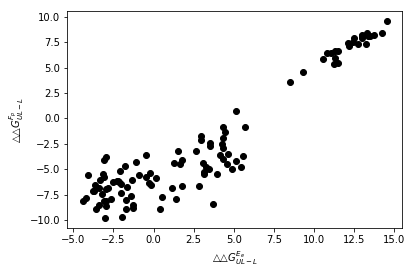

In [136]:
outputpath=r'/Users/PC/Dropbox/cai/btype_cco/crg_data/DeltaE_E1vsDeltaE_F3.png'  # path to store the figure

fig, ax=plt.subplots()
ax.scatter(df_res[r'$\bigtriangleup$E_e1'],df_res[r'$\bigtriangleup$E_f3'],color='black')
ax.set_xlabel(r'$\bigtriangleup$$\bigtriangleup$$G^{E_e}_{UL-L}$')
ax.set_ylabel(r'$\bigtriangleup$$\bigtriangleup$$G^{F_p}_{UL-L}$')

#plt.savefig(outputpath, dpi=300,bbox_inches='tight')
plt.show()

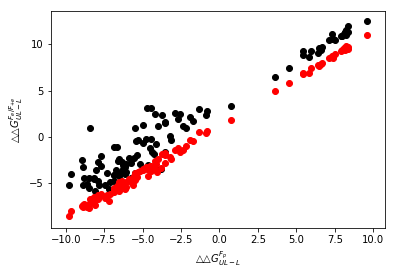

In [149]:
fig, ax=plt.subplots()
ax.scatter(df_res[r'$\bigtriangleup$E_f3'],df_res[r'$\bigtriangleup$E_f1'], color='black')
ax.scatter(df_res[r'$\bigtriangleup$E_f3'],df_res[r'$\bigtriangleup$E_f5'], color='red')
ax.set_xlabel(r'$\bigtriangleup$$\bigtriangleup$$G^{F_p}_{UL-L}$')
ax.set_ylabel(r'$\bigtriangleup$$\bigtriangleup$$G^{F_e/F_{+e}}_{UL-L}$')

#plt.savefig(outputpath, dpi=300,bbox_inches='tight')
plt.show()

Estimated coefficients:
b_0 = -5.463655861935308
b_1 = 0.9307257612868138


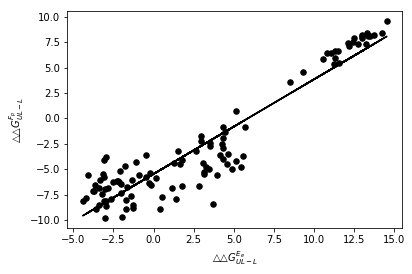

In [153]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
    
  
def plot_regression_line(x, y, b,x_label='x',y_label='y', *args, **kwargs): 
    
    filename=kwargs.get('filename', None)
    
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color='black',
               marker = "o", s = 30) 
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    plt.plot(x, y_pred, color = "k") 
  
    # putting labels 
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    
    #save the figure
    if filename:
        plt.savefig(filename, dpi=300,bbox_inches='tight')
  
    # function to show plot 
    plt.show() 
  
def main(x,y,x_label='x',y_label='y', *args, **kwargs): 
    filename=kwargs.get('filename', None)
    
    # observations 
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
  
    # plotting regression line
    plot_regression_line(x, y, b, x_label, y_label, filename=filename) 
  
if __name__ == "__main__": 
    
    outputpath=r'/Users/PC/Dropbox/cai/btype_cco/crg_data/DeltaE_E1vsDeltaE_F3_fitting.png'  # path to store the figure
    main(df_res[r'$\bigtriangleup$E_e1'],df_res[r'$\bigtriangleup$E_f3'], \
         x_label=r'$\bigtriangleup$$\bigtriangleup$$G^{E_e}_{UL-L}$',\
         y_label=r'$\bigtriangleup$$\bigtriangleup$$G^{F_p}_{UL-L}$',\
         filename=outputpath)
    
    

In [38]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
    
  
def plot_regression_line(x, ys, bs,x_label='x',y_label='y', *args, **kwargs): 
    
    filename=kwargs.get('filename', None)
    
    colors_choice=['black', 'red', 'blue']
    for i,y in enumerate(ys): 
        # plotting the actual points as scatter plot 
        plt.scatter(x, y, color=colors_choice[i] ,marker = "o", s = 30) 
  
        # predicted response vector 
        y_pred = bs[i][0] + bs[i][1]*x 
  
        # plotting the regression line 
        plt.plot(x, y_pred, color = colors_choice[i]) 
    
    # putting labels 
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    
    #save the figure
    if filename:
        plt.savefig(filename, dpi=300,bbox_inches='tight')
  
    # function to show plot 
    plt.show() 
  
def main(x,ys, x_label='x',y_label='y', *args, **kwargs): 
    filename=kwargs.get('filename', None)
    
    # observations 
  
    # estimating coefficients
    bs=[]
    for y in ys:
        b = estimate_coef(x, y)
        print("Estimated coefficients y1:\nb_0 = {}\nb_1 = {}".format(b[0], b[1]))
        bs.append(b)
    
  
    # plotting regression line
    plot_regression_line(x, ys, bs, x_label, y_label, filename=filename) 
  
if __name__ == "__main__": 
    
    outputpath=r'/Users/PC/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/DeltaE_F3vsDeltaE_F1NF5_fitting.tiff'  # path to store the figure
    main(df_res[r'$\bigtriangleup$E_f3'],
         [df_res[r'$\bigtriangleup$E_e1'],df_res[r'$\bigtriangleup$E_f1'],df_res[r'$\bigtriangleup$E_f5']],
         x_label=r'$\bigtriangleup$$\bigtriangleup$$G^{F_p}_{UL-L}$',\
         y_label=r'$\bigtriangleup$$\bigtriangleup$$G^{E_e/F_e/F_{+e}}_{UL-L}$',\
         filename=outputpath)



Estimated coefficients y1:
b_0 = 5.5138457901006515
b_1 = 0.9415420883508927
Estimated coefficients y1:
b_0 = 3.483826807521236
b_1 = 0.9458749033485987
Estimated coefficients y1:
b_0 = 1.249837649416599
b_1 = 1.0102696683780081


TypeError: Cannot cast array data from dtype('<U3') to dtype('float64') according to the rule 'safe'

# group the data by traj/xray and summarize the information

In [164]:
groups=df_res.groupby('traj/xray')[[r'$\int$dsum_pls6_m2','sum_pls6_avecrg',r'$\bigtriangleup$E_e1',r'$\bigtriangleup$E_f3']]\
.agg(['mean','std','size']).reset_index()

# style the dataframe and save the dataframe to excel file

In [165]:
def color_struc(s, color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    #copy df to new - original data are not changed
    df = s.copy()
    #set by condition
    df.loc[:,:] = 'background-color: blue '
    for key in color_map:
        
        mask = s[column] == key
        #print(mask)
        df.loc[mask, :] = 'background-color: {}'.format(color_map.get(key))
    #print(df)
    return df    

#colormap of each structure
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}

df_res_styler=df_res.round(2).style.apply(color_struc, color_map=color_maps, column='traj/xray', axis=None)

In [30]:
'''
outputpath=r'C:\Users\PC\Dropbox\cai\btype_cco\crg_data\summary_96md_12xry_alys.xlsx'
writer=pandas.ExcelWriter(outputpath,engine = 'xlsxwriter')

df_res_styler.to_excel(writer,sheet_name='complete_data')
df_res_styler.to_excel(writer, \
                       sheet_name='brief_data',\
                       columns=['state_snap', 'traj/xray', 'time_point','cluster_size',
                                'PAAK9301_avecrg±std',  'PDDK9302_avecrg±std',
                                'DA0287_avecrg±std', 'DA0372_avecrg±std', 'HA0376_avecrg±std', 'EB0126_avecrg±std',
                                'sum_pls6_avecrg', 'sum_pls6_std',
       'sum_pls6_avecrg±std', '$\int$dsum_pls6_m1', '$\int$dsum_pls6_m2',
       'E(-3)_min_e1', 'E(-4)_min_e1',
       'E_self(-3)_e1', 'E_self(-4)_e1', 'E_pw(-3)_e1', 'E_pw(-4)_e1',
       'E_mfe(-3)_e1', 'E_mfe(-4)_e1', r'$\bigtriangleup$E_e1',
       r'$\bigtriangleup$E_self_e1', r'$\bigtriangleup$E_pw_e1',
       r'$\bigtriangleup$E_mfe_e1', 'E(-3)_min_f3', 'E(-4)_min_f3',
        'E_self(-3)_f3', 'E_self(-4)_f3',
       'E_pw(-3)_f3', 'E_pw(-4)_f3', 'E_mfe(-3)_f3', 'E_mfe(-4)_f3',
       r'$\bigtriangleup$E_f3', r'$\bigtriangleup$E_self_f3',
       r'$\bigtriangleup$E_pw_f3', r'$\bigtriangleup$E_mfe_f3'])
groups.round(2).to_excel(writer, sheet_name='groupbytraj')
writer.save()
writer.close()
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 16-17: truncated \UXXXXXXXX escape (<ipython-input-30-ce3433b0c97c>, line 25)

# Group microstates by structures and average charge of PLS

In [166]:
df_res_sorted = df_res.sort_values(by='sum_pls6_avecrg',ascending=False)
bins =  [-2.00, -2.995, -3.005, -3.995,-4.004, -5.00]
ind = np.digitize(df_res_sorted['sum_pls6_avecrg'],bins)

#print(df_res_sorted)
ms_groups=df_res_sorted.groupby(ind)

for x, data in ms_groups:
    print(data['sum_pls6_avecrg'].size)
    #print(data[r'$\int$dsum_pls6_m2'].max(),data[r'$\int$dsum_pls6_m2'].min() )
    #print(data[r'$\bigtriangleup$E_f3'].max(),data[r'$\bigtriangleup$E_f3'].min() )
    #print(list(data[r'$\int$dsum_pls6_m2']))
    print(data[r'$\bigtriangleup$E_self_e1'].min(), data[r'$\bigtriangleup$E_self_e1'].max())
    print(data[r'$\bigtriangleup$E_pw_e1'].min(), data[r'$\bigtriangleup$E_pw_e1'].max())
    print(data[r'$\bigtriangleup$E_mfe_e1'].min(), data[r'$\bigtriangleup$E_mfe_e1'].max())
    print(data[r'$\bigtriangleup$E_self_f3'].min(), data[r'$\bigtriangleup$E_self_f3'].max())
    print(data[r'$\bigtriangleup$E_pw_f3'].min(), data[r'$\bigtriangleup$E_pw_f3'].max())
    print(data[r'$\bigtriangleup$E_mfe_f3'].min(), data[r'$\bigtriangleup$E_mfe_f3'].max())
    
    
    keys=['str_ms(-3)_minE_e1','str_ms(-4)_minE_e1','str_ms(-3)_minE_f3','str_ms(-4)_minE_f3']
    
    for key in keys:
        for i, value in collections.Counter(list(data[key])).items():
            #print(i,value)
            print(crgstringtolist(i), value)
        print('\n')
            

    
    #print(list(map(crgstringtolist,set(data['str_ms(-3)_minE_e1']))),'\n',
    #      list(map(crgstringtolist,set(data['str_ms(-4)_minE_e1']))),'\n',
    #      list(map(crgstringtolist,set(data['str_ms(-3)_minE_f3']))),'\n',
    #      list(map(crgstringtolist,set(data['str_ms(-4)_minE_f3']))))

1
-6.647880000000001 -6.647880000000001
40.444900000000004 40.444900000000004
-20.54630199999984 -20.54630199999984
8.841500000000003 8.841500000000003
19.8154 19.8154
-21.352683999999982 -21.352683999999982
[-1, 0, 1, -1, -1, -1] 1


[-1, 0, 0, -1, -1, -1] 1


[-1, 0, 1, -1, -1, -1] 1


[-1, -1, 1, -1, -1, -1] 1


24
-9.944780000000002 8.66020000000001
22.71710000000001 46.5681
-24.93581799999984 -15.011143999999888
-9.892479999999999 -3.8607799999999983
36.402600000000014 46.5681
-29.86260800000001 -22.226161000000133
[-1, 0, 1, -1, -1, -1] 23
[-1, 0, 0, -1, 0, -1] 1


[-1, 0, 0, -1, -1, -1] 23
[-1, -1, 0, -1, 0, -1] 1


[-1, 0, 1, -1, -1, -1] 24


[-1, 0, 0, -1, -1, -1] 24


63
-9.37868 8.601100000000002
9.061600000000002 34.57730000000001
-26.59884499999997 -14.64706700000012
-10.168980000000005 9.1543
12.391299999999989 34.57730000000001
-34.63324800000005 -19.48732300000006
[-1, 0, 1, -1, -1, -1] 6
[-1, 0, 0, -1, 0, -1] 51
[-1, -1, 1, -1, 0, -1] 3
[-1, 0, 0, -1, -1, 0] 1
[-1, 0, 

In [167]:
#save sorted dataframe to excel
'''

outputpath='/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/summary_96md_12xry_5categories.xlsx'
writer=pandas.ExcelWriter(outputpath,engine = 'xlsxwriter')

sheet_name=['cat1-prime','cat1','cat2','cat3','cat4']
for x, data in ms_groups:
    #print(x)
    data.to_excel(writer,sheet_name=sheet_name[x-1])
    


writer.save()
writer.close()
'''

"\n\noutputpath='/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/summary_96md_12xry_5categories.xlsx'\nwriter=pandas.ExcelWriter(outputpath,engine = 'xlsxwriter')\n\nsheet_name=['cat1-prime','cat1','cat2','cat3','cat4']\nfor x, data in ms_groups:\n    #print(x)\n    data.to_excel(writer,sheet_name=sheet_name[x-1])\n    \n\n\nwriter.save()\nwriter.close()\n"

## Plot energy terms vs Structs

In [168]:
def plotenergyterms(tot_enes:list, enes_terms:list, *args, **kwargs)-> None:
    filename=kwargs.get('filename', None)
    x_ticks=kwargs.get('x_ticks',None)
    y_label=kwargs.get('y_label',[r'$\bigtriangleup$$\bigtriangleup$$G^{E_e}_{UL-L}$', \
                                  r'$\bigtriangleup$$\bigtriangleup$$G^{E_e}_{UL-L}$ terms'])
    top_xlabel=kwargs.get('top_xlabel', 'Category')
    x_cat=kwargs.get('x_cat', [0,1,25, 88, 94, 107])
    x_cat_ticklabels=kwargs.get('x_cat_ticklabels', ['1\'','1','2', '3', '4'])
    colors=kwargs.get('colors', 'b')
    
    
    x_cat_minor=[]
    
    #reverse the category
    x_cat=-np.array(x_cat)+107
    for i in range(1,len(x_cat)):
        x_cat_minor.append((x_cat[i]+x_cat[i-1])/2)
    
    figlabel=['A','B']
    
    fig, axes=plt.subplots(2,sharex=True,gridspec_kw={'hspace': 0} )
    for i, ax in enumerate(axes):
        if i==0: 
            ax.bar(list(range(len(tot_enes))), tot_enes, width=0.5,color=colors)
            
        if i==1:
            cs=['b-','r-','g-','p-','o-','y-']
            for a,x in enumerate(enes_terms):
                ax.plot(np.arange(0,len(x),1),x,cs[a])
                
        
        
        if x_ticks:
            ax.set_xticks(x_ticks)
        ax.set_ylabel(y_label[i])
        ax.text(-0.1, 1.05, figlabel[i], transform=ax.transAxes,
               fontsize=16, va='top', ha='right')
    
        
        xstart, xend=len(x_cat), 0
        for j, cat in enumerate(x_cat[1:]):   #plot division vertical lines    
            if 0 < cat < len(tot_enes):
                xstart, xend=min(j, xstart), max(xend,j)      
                ax.axvline(x=cat,color='k', linestyle='--', lw=0.7)
    
        ax.axhline(y=0,color='k', linestyle='--', lw=0.7)    
        
        #x axis on the top
        if i==0:
            ax3 = ax.twiny()
            ax3.tick_params(axis="x", direction="in", length=0, width=2)
            ax3.set_xlim(ax.get_xlim())
            ax3.set_xticks(x_cat_minor[xstart: xend+2])            
            ax3.set_xticklabels(x_cat_ticklabels[xstart: xend+2])
            ax3.set_xlabel(top_xlabel)
                       

    ax.set_xlabel('Structure')
    
    
    if filename:
        fig.savefig(filename, dpi=300,bbox_inches='tight')
    plt.show()
    

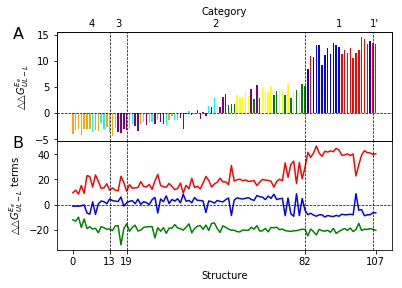

In [169]:
outputpath='/Users/PC/Dropbox/cai/btype_cco/crg_data/dEVsStrucs_e1.png'


sheet_name=['cat1-prime','cat1','cat2','cat3','cat4']
totE, selfE, pwE, mfe=[],[],[],[]
colors=[]

color_map={"p1": "orange",  "p2": "purple",  "p3": "green", \
           "p4": "cyan","d372p":"yellow", "d372ph376p": "red"}

for x, data in ms_groups:
    totE.extend(list(data[r'$\bigtriangleup$E_e1']))
    selfE.extend(list(data[r'$\bigtriangleup$E_self_e1']))
    pwE.extend(list(data[r'$\bigtriangleup$E_pw_e1']))
    mfe.extend(list(data[r'$\bigtriangleup$E_mfe_e1']))
    colors.extend([ color_map.get(s,"blue") for s in list(data['traj/xray']) ])
    

plotenergyterms(totE[::-1], [selfE[::-1], pwE[::-1],mfe[::-1]],\
                colors=colors[::-1],x_ticks=[0,13,19,82,107],
               filename=outputpath)

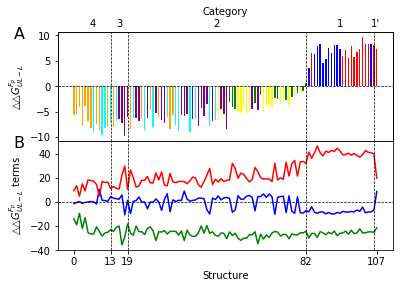

In [170]:
outputpath='/Users/PC/Dropbox/cai/btype_cco/crg_data/dEVsStrucs_f3.png'


sheet_name=['cat1-prime','cat1','cat2','cat3','cat4']
totE_f3, selfE_f3, pwE_f3, mfe_f3=[],[],[],[]
colors=[]

color_map={"p1": "orange",  "p2": "purple",  "p3": "green", \
           "p4": "cyan","d372p":"yellow", "d372ph376p": "red"}

for x, data in ms_groups:
    totE_f3.extend(list(data[r'$\bigtriangleup$E_f3']))
    selfE_f3.extend(list(data[r'$\bigtriangleup$E_self_f3']))
    pwE_f3.extend(list(data[r'$\bigtriangleup$E_pw_f3']))
    mfe_f3.extend(list(data[r'$\bigtriangleup$E_mfe_f3']))
    colors.extend([ color_map.get(s,"blue") for s in list(data['traj/xray']) ])
    

plotenergyterms(totE_f3[::-1], [selfE_f3[::-1], pwE_f3[::-1],mfe_f3[::-1]],\
                colors=colors[::-1],x_ticks=[0,13,19,82,107],
                y_label=[r'$\bigtriangleup$$\bigtriangleup$$G^{F_p}_{UL-L}$',
                         r'$\bigtriangleup$$\bigtriangleup$$G^{F_p}_{UL-L}$ terms'],
               filename=outputpath)

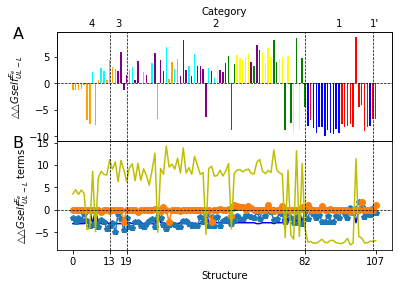

In [173]:
outputpath='/Users/PC/Dropbox/cai/btype_cco/crg_data/figures/energies/dE_selfVsStrucs_e1.png'


sheet_name=['cat1-prime','cat1','cat2','cat3','cat4']
selfE_pka,selfE_vdw0,selfE_vdw1,selfE_epol,selfE_tors,selfE_dsolv=[],[],[],[],[],[]
colors=[]

color_map={"p1": "orange",  "p2": "purple",  "p3": "green", \
           "p4": "cyan","d372p":"yellow", "d372ph376p": "red"}

for x, data in ms_groups: 
    selfE_pka.extend(list(data[r'$\bigtriangleup$E_self_pka_e1']))
    selfE_vdw0.extend(list(data[r'$\bigtriangleup$E_self_vdw0_e1']))
    selfE_vdw1.extend(list(data[r'$\bigtriangleup$E_self_vdw1_e1']))
    selfE_epol.extend(list(data[r'$\bigtriangleup$E_self_epol_e1']))
    selfE_tors.extend(list(data[r'$\bigtriangleup$E_self_tors_e1']))
    selfE_dsolv.extend(list(data[r'$\bigtriangleup$E_self_dsolv_e1']))
    
    colors.extend([ color_map.get(s,"blue") for s in list(data['traj/xray']) ])
    

plotenergyterms(selfE[::-1], [selfE_pka[::-1],selfE_vdw0[::-1],selfE_vdw1[::-1],selfE_epol[::-1],selfE_tors[::-1],selfE_dsolv[::-1]],\
                colors=colors[::-1],x_ticks=[0,13,19,82,107],
               filename=outputpath,
               y_label=[r'$\bigtriangleup$$\bigtriangleup$$Gself^{E_e}_{UL-L}$', \
                                  r'$\bigtriangleup$$\bigtriangleup$$Gself^{E_e}_{UL-L}$ terms'])

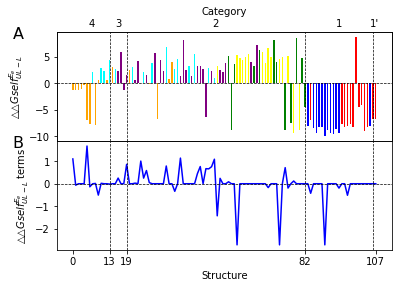

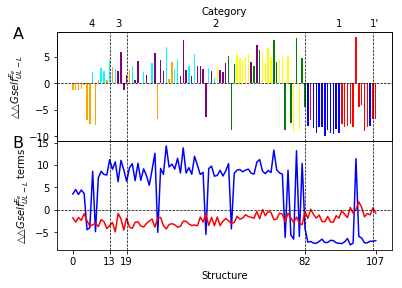

In [194]:
import numpy as np
selfE_bk=np.array([selfE_vdw1,selfE_epol]).sum(axis=0)

test= selfE_tors
plotenergyterms(selfE[::-1], [test],\
                colors=colors[::-1],x_ticks=[0,13,19,82,107],
               y_label=[r'$\bigtriangleup$$\bigtriangleup$$Gself^{E_e}_{UL-L}$', \
                                  r'$\bigtriangleup$$\bigtriangleup$$Gself^{E_e}_{UL-L}$ terms'])

outputpath='/Users/PC/Dropbox/cai/btype_cco/crg_data/figures/energies/dE_bkdsolvVsStrucs_e1.png'
plotenergyterms(selfE[::-1], [selfE_dsolv[::-1], selfE_bk[::-1]],\
                colors=colors[::-1],x_ticks=[0,13,19,82,107],
               y_label=[r'$\bigtriangleup$$\bigtriangleup$$Gself^{E_e}_{UL-L}$', \
                                  r'$\bigtriangleup$$\bigtriangleup$$Gself^{E_e}_{UL-L}$ terms'],
               filename=outputpath)

In [189]:
selfE_vdw0.index(0.4790000000000003)

36

In [167]:
'''
check if the data is right
'''
'''
for l in zip(*[selfE[::-1], selfE_pka[::-1],selfE_vdw[::-1],selfE_epol[::-1],selfE_tors[::-1],selfE_dsolv[::-1]]):
    if sum(l[1:])-l[0] > 10e-6:
        print('Error')

for l in zip(*[selfE[::-1], selfE_bk[::-1],selfE_dsolv[::-1]]):
    if sum(l[1:])-l[0] > 10e-6:
        print('Error')
'''

    

In [19]:
#snapshot categorizing
print([list(data['state_snap']) for x, data in ms_groups])
    

[['d372ph376p_288_frame'], ['d372ph376p_141_frame', '3eh4', 'd372ph376p_404_frame', 'd372ph376p_55_frame', 'd372ph376p_456_frame', 'd372ph376p_432_frame', 'd372ph376p_411_frame', 'd372ph376p_243_frame', 'd372ph376p_166_frame', 'd372ph376p_68_frame', 'd372ph376p_368_frame', 'd372ph376p_255_frame', '3s8f', '3s3b', '1ehk', '1xme', '4gp4', '4gp5', '3eh3', '3eh5', '3s3d', '3s3a', 'd372ph376p_468_frame', '3s3c'], ['p3_435_frame', 'p3_190_frame', 'd372p_18_frame', 'p3_218_frame', 'd372p_54_frame', 'p3_467_frame', 'd372p_151_frame', 'p3_297_frame', 'd372p_253_frame', 'd372p_287_frame', 'p3_186_frame', 'p3_98_frame', 'd372p_365_frame', 'd372p_179_frame', 'd372p_152_frame', 'd372p_207_frame', 'p3_443_frame', 'p2_139_frame', 'p3_419_frame', 'p2_145_frame', 'd372p_167_frame', 'd372p_370_frame', 'd372p_318_frame', 'd372p_230_frame', 'd372p_289_frame', 'p3_494_frame', 'p3_226_frame', 'p3_132_frame', 'p2_148_frame', 'p2_359_frame', 'p2_25_frame', 'd372p_491_frame', 'p4_219_frame', 'p2_126_frame', 'p4

In [172]:
#snapshot categorizing
print([list(data['sum_pls6_avecrg']) for x, data in ms_groups])

[[-2.9825000000000004], [-2.9958333333333336, -2.9958333333333336, -2.9958333333333336, -2.9966666666666666, -2.9975, -2.9975, -2.9983333333333335, -2.999166666666667, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.000833333333333, -3.0016666666666665], [-3.035, -3.11, -3.170833333333334, -3.1799999999999997, -3.213333333333333, -3.308333333333333, -3.3141666666666665, -3.318333333333334, -3.3200000000000003, -3.345, -3.3516666666666666, -3.3608333333333333, -3.364166666666667, -3.3833333333333333, -3.435, -3.4566666666666666, -3.464166666666667, -3.4716666666666662, -3.515833333333333, -3.5250000000000004, -3.5558333333333327, -3.568333333333333, -3.6008333333333336, -3.624166666666667, -3.6308333333333334, -3.6774999999999998, -3.696666666666667, -3.7108333333333334, -3.7758333333333334, -3.784166666666667, -3.804166666666666, -3.805, -3.8058333333333327, -3.8516666666666666, -3.8525000000000005, -3.875833333333333, -3.8783333333333334, -3.8816

In [173]:
#snapshot categorizing
print([list(data[r'$\bigtriangleup$E_e1']) for x, data in ms_groups])



[[13.253036499023438], [13.474533081054688, 13.7607421875, 13.287445068359375, 14.265899658203097, 14.5472412109375, 12.128540039062614, 11.501182556152287, 10.545928955078182, 12.508026123046903, 11.5332870483399, 12.202041625976562, 11.291549682617216, 12.734191894531193, 13.017074584960994, 13.360450744628906, 11.339096069336009, 12.467864990234318, 11.2421875, 9.28930664062591, 12.991516113281307, 13.00411987304679, 10.846885681152315, 11.037399291992188, 8.513229370117216], [5.152229309082031, 5.6747283935546875, 4.338768005371094, 4.4558563232421875, 4.314796447753906, 2.974334716796875, 5.60295867919919, 3.54229736328125, 4.328987121582031, 4.667381286621094, 4.28164672851571, 3.5489120483399006, 5.119712829589844, 4.140048980712891, 4.326744079589815, 4.920989990234375, 2.9347839355469034, 5.4574127197265625, 2.656387329101591, 4.561737060546918, 3.2410125732421875, 3.9795989990235086, 3.07861328125, 3.1387176513671875, 3.44818115234375, 1.675445556640625, 1.7583389282226562, 1

In [20]:
list(ms_groups)

[(1,               state_snap   traj/xray time_point  PAAK9301_maxcrg  \
  19  d372ph376p_288_frame  d372ph376p        288            -0.85   
  
      PAAK9301_mincrg  PAAK9301_avecrg  PAAK9301_std PAAK9301_avecrg±std  \
  19             -1.0           -0.975      0.042747        -0.97 ± 0.04   
  
      PDDK9302_maxcrg  PDDK9302_mincrg      ...       E_self(-4)_f3  \
  19             -0.8             -1.0      ...            54.19198   
  
      E_pw(-3)_f3 E_pw(-4)_f3  E_mfe(-3)_f3  E_mfe(-4)_f3  $\bigtriangleup$E_f3  \
  19      -3.1623     16.6531    -51.663481    -62.339823              7.304123   
  
      $\bigtriangleup$E_self_f3 $\bigtriangleup$E_pw_f3  \
  19                     8.8415                 19.8154   
  
      $\bigtriangleup$E_mfe_f3  cluster_size  
  19                -21.352684          52.0  
  
  [1 rows x 75 columns]),
 (2,                state_snap   traj/xray time_point  PAAK9301_maxcrg  \
  106                  3s3c        3s3c        NaN            -0.58

In [142]:
collections.Counter(list(df_res["str_ms(-4)_minE_f3"]))

Counter({'-1-10-10-1': 20,
         '-1-100-1-1': 1,
         '-1-11-1-1-1': 8,
         '-100-1-1-1': 79})